# Univariate analysis using nistats:
Data set an be obtained from: https://openneuro.org/datasets/ds000114

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import glob

In [55]:
# load the data by entering the local path
func_data = glob.glob('C:/Users/ilkay/open_neuro_data/fmriprep/sub-*/ses-test/func/sub-*_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')

# define a path to save the zstat maps
save_path = 'C:\\Users\\ilkay\\open_neuro_data\\z_maps\\'

# define some params
nr_sub = len(func_data)
tr = 2.5
epoch_duration = 15 # in sec
n_scans = 184
#frame_times = np.arange(0, n_scans-4, 1)
frame_times = np.linspace(0, (n_scans - 5) * tr, n_scans)

In [35]:
#get the confounds file
conf_data = glob.glob('C:/Users/ilkay/open_neuro_data/fmriprep/sub-*/ses-test/func/sub-*task-fingerfootlips_bold_confounds.tsv')

# create a list of dataframes with motion confounds and framewise disp
motion_conf = []
for n in range(nr_sub):
    temp_df = pd.read_csv(conf_data[n], delimiter='\t')
    sub_motion_conf = pd.DataFrame(temp_df, columns=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ', 'FramewiseDisplacement'])
    sub_motion_conf['FramewiseDisplacement'][0] = 0 # change the first elem to 0 from Nan
    sub_motion_conf=sub_motion_conf.drop(sub_motion_conf.index[[0,1,2,3]])
    # print(sub_motion_conf.shape)
    motion_conf.append(sub_motion_conf)
    


(180, 7)
(180, 7)
(180, 7)
(180, 7)
(180, 7)
(180, 7)
(180, 7)
(180, 7)
(180, 7)
(180, 7)


In [36]:
# get the event onsets
onsets_dir = 'C:\\Users\\ilkay\\open_neuro_data\\onsets_fingerfootlips.csv'
events = pd.read_csv(onsets_dir)
# will delete the first 4 timepoints
events['onset'] -= 10
events_allsub = [events] * nr_sub # multiply events for all sub
events

,duration,onset,trial_type
0,15,0,Finger
1,15,30,Foot
2,15,60,Lips
3,15,90,Finger
4,15,120,Foot
5,15,150,Lips
6,15,180,Finger
7,15,210,Foot
8,15,240,Lips
9,15,270,Finger


In [9]:
# apply smoothing to the data and delete the 1st 4 time points
from nilearn import image 
func_data_sm = [] # initialize a list to put smoothed data
for n in range(nr_sub):
    func_data_sm.append(image.smooth_img(func_data[n], fwhm=8).slicer[..., 4:])

In [37]:
np.shape(func_data_sm[0])

(49, 58, 49, 180)

In [16]:
# check if the smoothing worked
from nilearn.plotting import plot_epi
mean_func = image.mean_img(func_data[0])
smoothed_img = func_data_sm[0]
mean_smoothed_img = image.mean_img(smoothed_img)

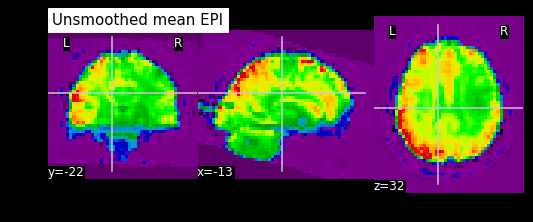

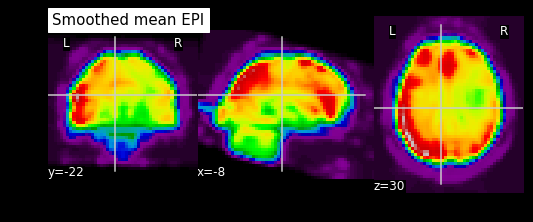

In [17]:
plot_epi(mean_func, title='Unsmoothed mean EPI')
plot_epi(mean_smoothed_img,  title='Smoothed mean EPI')

In [38]:
# define some model parameters
drift_model = None
period_cut = 4. * epoch_duration
hrf_model = 'glover + derivative'

# define the model
from nistats.first_level_model import FirstLevelModel
fmri_glm = FirstLevelModel(tr, noise_model='ar1',
                           standardize=False, hrf_model=hrf_model,
                           drift_model=drift_model, period_cut=period_cut)

fmri_glm = fmri_glm.fit(func_data_sm, events_allsub, confounds=motion_conf)

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:465: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  labels, results = mem_glm(Y, design.as_matrix(),
C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:60: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


In [39]:
from nistats.reporting import plot_design_matrix
design_matrix = fmri_glm.design_matrices_[0]

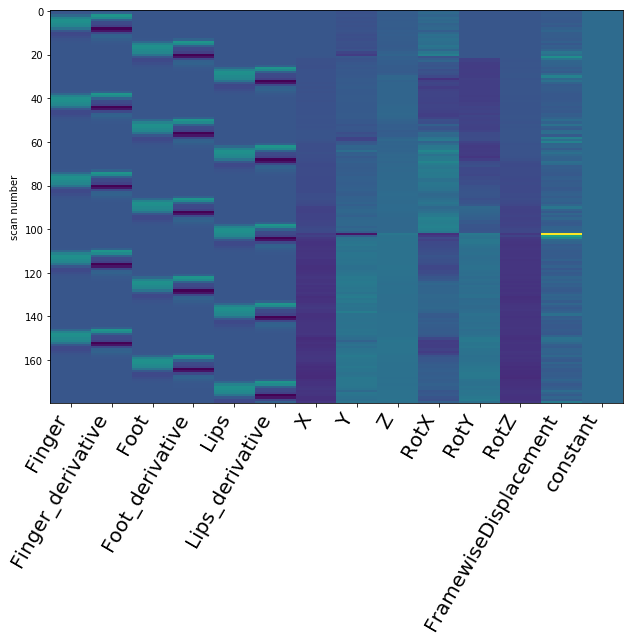

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,9))
plot_design_matrix(design_matrix, ax=ax)

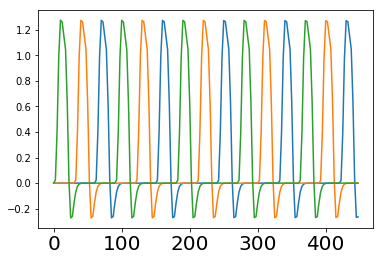

In [43]:
# contrast matrix
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])
import matplotlib.pyplot as plt
plt.plot(design_matrix['Lips'])
plt.plot(design_matrix['Foot'])
plt.plot(design_matrix['Finger'])

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 10 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


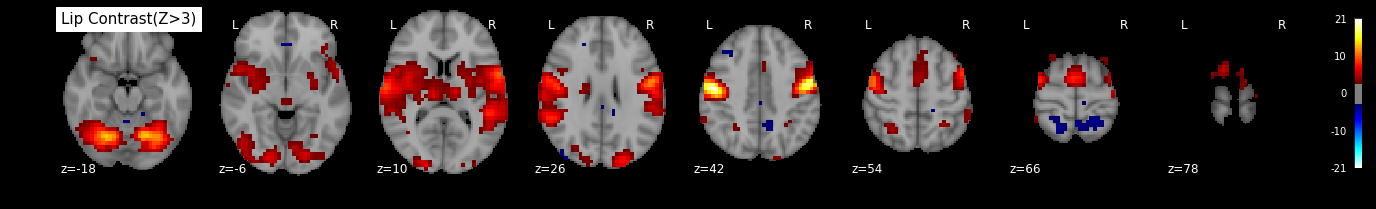

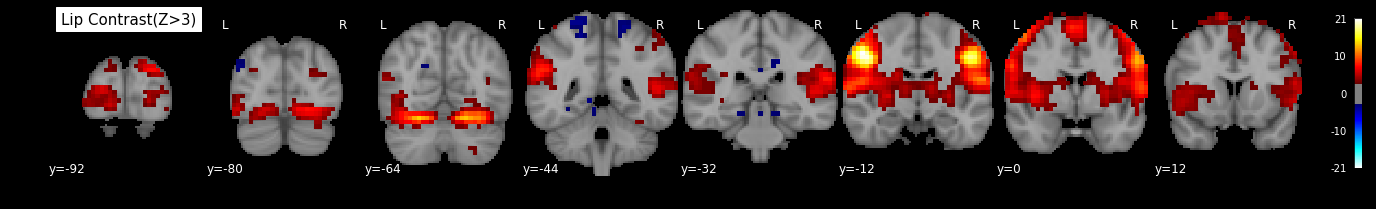

In [44]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
z_map_lip = fmri_glm.compute_contrast('Lips', output_type='z_score')
p_map_lip = fmri_glm.compute_contrast('Lips', output_type='p_value')

plot_stat_map(z_map_lip, threshold=3.0,
              display_mode='z', cut_coords=8, black_bg=True,
              title='Lip Contrast(Z>3)')
plot_stat_map(z_map_lip, threshold=3,
              display_mode='y', cut_coords=8, black_bg=True,
              title='Lip Contrast(Z>3)')

save_name = save_path + 'zmap_lip' + '.nii.gz'
z_map_lip.to_filename(save_name)

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 10 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


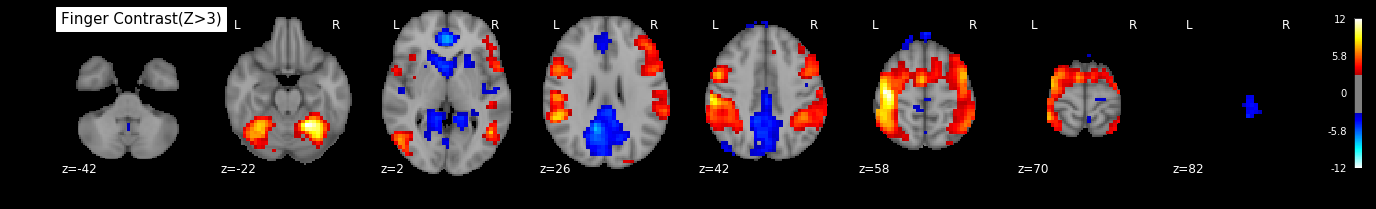

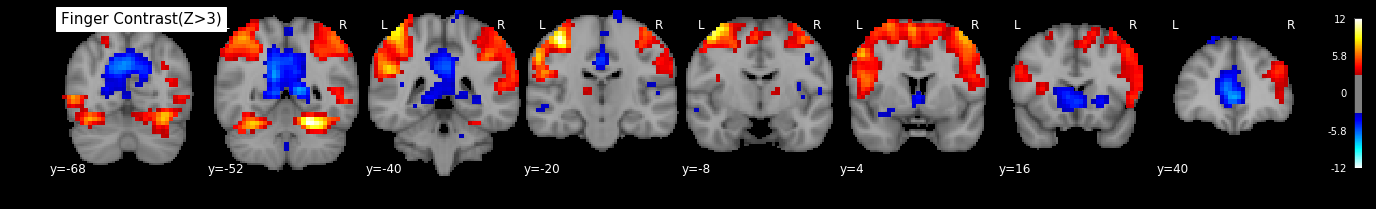

In [45]:
z_map_finger = fmri_glm.compute_contrast('Finger', output_type='z_score')
p_map_finger = fmri_glm.compute_contrast('Finger', output_type='p_value')

plot_stat_map(z_map_finger, threshold=3,
              display_mode='z', cut_coords=8, black_bg=True,
              title='Finger Contrast(Z>3)')
plot_stat_map(z_map_finger, threshold=3,
              display_mode='y', cut_coords=8, black_bg=True,
              title='Finger Contrast(Z>3)')

save_name = save_path + 'zmap_finger' + '.nii.gz'
z_map_finger.to_filename(save_name)

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 10 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


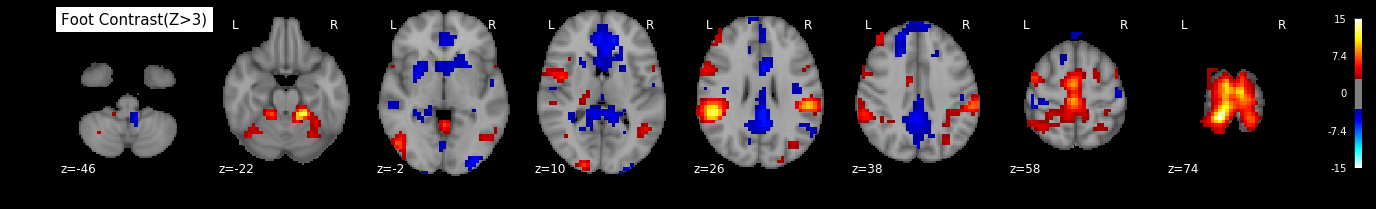

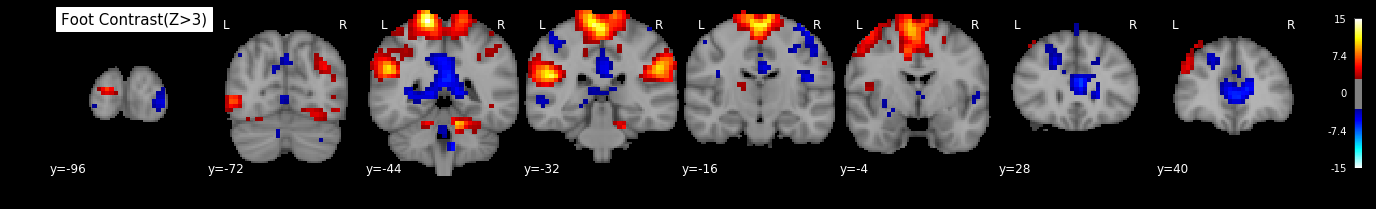

In [46]:
z_map_foot = fmri_glm.compute_contrast('Foot', output_type='z_score')
p_map_foot = fmri_glm.compute_contrast('Foot', output_type='p_value')

plot_stat_map(z_map_foot, threshold=3,
              display_mode='z', cut_coords=8, black_bg=True,
              title='Foot Contrast(Z>3)')
plot_stat_map(z_map_foot, threshold=3,
              display_mode='y', cut_coords=8, black_bg=True,
              title='Foot Contrast(Z>3)')

save_name = save_path + 'zmap_foot' + '.nii.gz'
z_map_foot.to_filename(save_name)

# Extract signal from voxels

In [48]:
# Find the coordinates of the peak
from nibabel.affines import apply_affine
values = z_map_lip.get_data()
coord_peaks = np.dstack(np.unravel_index(np.argsort(values.ravel()),
                                         values.shape))[0, 0, :]
coord_mm = apply_affine(z_map_lip.affine, coord_peaks)

In [49]:
from nilearn.input_data import NiftiSpheresMasker
mask = NiftiSpheresMasker([coord_mm], radius=3,
                          detrend=True, standardize=True,
                          high_pass=None, low_pass=None, t_r=tr)
sig = mask.fit_transform(func_data_sm[6])

In [56]:
frame_times

array([  0.        ,   2.44535519,   4.89071038,   7.33606557,
         9.78142077,  12.22677596,  14.67213115,  17.11748634,
        19.56284153,  22.00819672,  24.45355191,  26.8989071 ,
        29.3442623 ,  31.78961749,  34.23497268,  36.68032787,
        39.12568306,  41.57103825,  44.01639344,  46.46174863,
        48.90710383,  51.35245902,  53.79781421,  56.2431694 ,
        58.68852459,  61.13387978,  63.57923497,  66.02459016,
        68.46994536,  70.91530055,  73.36065574,  75.80601093,
        78.25136612,  80.69672131,  83.1420765 ,  85.58743169,
        88.03278689,  90.47814208,  92.92349727,  95.36885246,
        97.81420765, 100.25956284, 102.70491803, 105.15027322,
       107.59562842, 110.04098361, 112.4863388 , 114.93169399,
       117.37704918, 119.82240437, 122.26775956, 124.71311475,
       127.15846995, 129.60382514, 132.04918033, 134.49453552,
       136.93989071, 139.3852459 , 141.83060109, 144.27595628,
       146.72131148, 149.16666667, 151.61202186, 154.05

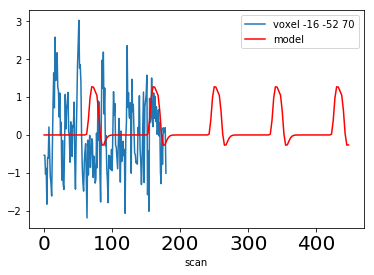

In [59]:

plt.plot(sig, label='voxel %d %d %d' % tuple(coord_mm))
plt.plot(design_matrix['Lips'], color='red', label='model')
plt.xlabel('scan')
plt.legend()
plt.show()